# Assignment 1: Street View {-}
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build a model that recognizes the correct digit.

In [1]:
%matplotlib inline

import openml as oml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import timeit
import time
import warnings
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn
warnings.filterwarnings('ignore')

In [2]:
# Download Streetview data. Takes a while the first time.
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

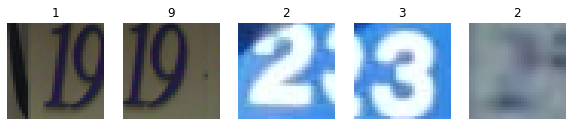

In [3]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:5], y[0:5]);

## 1. Evaluate different models (15 points) {-}
- Take a stratified 10% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample. 

In [4]:
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=9) # 10% of total dataset
sss.get_n_splits(X, y)
sample10idx = [s for s in sss.split(X, y)][0][1] #use the first split ([0]) and use the testset of this split as sample ([1])
sample_y = np.take(y, sample10idx) #take all the values in y that have an index in sample10idx
sample_X = [X[idx] for idx in sample10idx] #take all the values in X that have an index in sample10idx

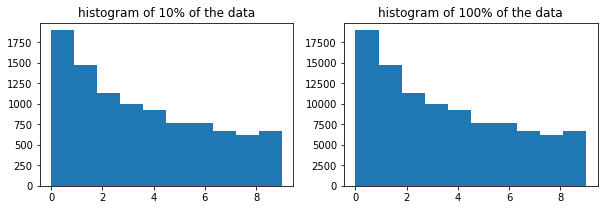

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
axes[0].hist(sample_y);
axes[1].hist(y);
axes[0].title.set_text('histogram of 10% of the data')
axes[1].title.set_text('histogram of 100% of the data')

- Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. 
    - Use cross-validation with 3 folds, output the training accuracy and test accuracy including the standard deviations.
    - Discuss the results. Are they what you expected? Are the model over/underfitting? What does the standard deviation tell you? Do you think you can get better results with more training data?

In [8]:
KNN = KNeighborsClassifier(n_jobs = -1)
CV_knn= sklearn.model_selection.cross_validate(KNN, sample_X, sample_y, cv=3, return_train_score=True) 

In [10]:
print('train_accuracy: ', CV_knn['train_score'].mean() )
print('train_std: ' ,CV_knn['train_score'].std() )
print('test_accuracy: ' ,CV_knn['test_score'].mean() ) 
print('test_std: ' ,CV_knn['test_score'].std() )

train_accuracy:  0.5606304953435445
train_std:  0.002424529793803634
test_accuracy:  0.3437412812316641
test_std:  0.002435926930591816


In [11]:
lr = LogisticRegression(n_jobs = -1, random_state=1)
CV_lr = sklearn.model_selection.cross_validate(lr, sample_X, sample_y, scoring='accuracy', cv=3, n_jobs=-1, return_train_score=True)

In [13]:
print('train_accuracy: ', CV_lr['train_score'].mean() )
print('train_std: ' ,CV_lr['train_score'].std() )
print('test_accuracy: ' ,CV_lr['test_score'].mean() ) 
print('test_std: ' ,CV_lr['test_score'].std() )

train_accuracy:  0.7411123240113463
train_std:  0.004167581350236303
test_accuracy:  0.169301980110807
test_std:  0.005037314171191079


In [43]:
svm = LinearSVC(random_state=1)
CV_svm = sklearn.model_selection.cross_validate(svm, sample_X, sample_y, cv=3, return_train_score=True, scoring='accuracy')

In [15]:
print('train_accuracy: ', CV_svm['train_score'].mean() )
print('train_std: ' ,CV_svm['train_score'].std() )
print('test_accuracy: ' ,CV_svm['test_score'].mean() ) 
print('test_std: ' ,CV_svm['test_score'].std() )

train_accuracy:  0.2708451329887149
train_std:  0.059706595704497926
test_accuracy:  0.16205644518397821
test_std:  0.020047923983762074


For KNN, lr and the linear svm the results are in line with our expectations. The results are not good. This is what we expected, because we use the default parameters and there are over 3000 features. The gap between the training and test accuracy might indicate overfitting. The standard deviation is very low, indicating that the accuracy for the 3 different folds is very similar. This means that the splits represent the original data well. The test accuracy could improve by adding more training data, because the general rule of thumb is that the cure to overfitting is more data. 

## 2. Learning curves (20 points) {-}
- Start with a 1% stratified subsample of the original data. Train all 3 classifiers and record both the accuracy (same as above) and the [training time](https://pythonhow.com/measure-execution-time-python-code/).
- Repeatedly **add** 1% more statified data (don't take a completely new 2% subsample). Measure accuracy and training time again.
- Continue to at least 10% of the original data. Plot the results as a line graph, with training set size on the x-axis and accuracy and training time, respectively, on the y-axes.
    - If the algorithms are sufficiently fast, you can continue to 100% as well.
- Discuss your results. Which algorithms are fast/slow? Which require more data to get better results? Which ones tend to overfit? Which ones would benefit from more data?

In [5]:
#Global variables

amount_iterations = 10
all_accuracy_train_KNN = np.empty(shape=amount_iterations) 
all_accuracy_test_KNN = np.empty(shape=amount_iterations)
all_fit_time_KNN = np.empty(shape=amount_iterations)

all_accuracy_train_logistic = np.empty(shape=amount_iterations) 
all_accuracy_test_logistic = np.empty(shape=amount_iterations)
all_fit_time_logistic = np.empty(shape=amount_iterations)

all_accuracy_train_linear = np.empty(shape=amount_iterations) 
all_accuracy_test_linear = np.empty(shape=amount_iterations)
all_fit_time_linear = np.empty(shape=amount_iterations)


In [6]:
#Helper functions overview:

#Creating functions for the classifiers:
def R2_KNN(data_X, data_y):
    KNN = KNeighborsClassifier()
    R2_KNN = sklearn.model_selection.cross_validate(KNN, data_X, data_y, cv=3, return_train_score=True) 
    return R2_KNN

def logistic_regression(data_X, data_y):
    lr = LogisticRegression(random_state=1)
    R2_lr = sklearn.model_selection.cross_validate(lr, data_X, data_y, cv=3, return_train_score=True, scoring='accuracy')
    return R2_lr

def linear(data_X, data_y):
    svm = LinearSVC(random_state=1)
    R2_svm = sklearn.model_selection.cross_validate(svm, data_X, data_y, cv=3, return_train_score=True)
    return R2_svm


#Creating helperfunctions for the results, these are put into an array, which is defined globally
def results_KNN():
    R2_KNN_results = R2_KNN(data_X, data_y)
    all_accuracy_train_KNN[-amount_iterations] = R2_KNN_results['train_score'].mean()
    all_accuracy_test_KNN[-amount_iterations] = R2_KNN_results['test_score'].mean()
    all_fit_time_KNN[-amount_iterations] = R2_KNN_results['fit_time'].mean()
    
def logistic_regression_results():
    R2_lr = logistic_regression(data_X, data_y)
    all_accuracy_train_logistic[-amount_iterations] = R2_lr['train_score'].mean()
    all_accuracy_test_logistic[-amount_iterations] = R2_lr['test_score'].mean()
    all_fit_time_logistic[-amount_iterations] = R2_lr['fit_time'].mean() 
    
def results_linear():
    R2_svm = linear(data_X, data_y)
    all_accuracy_train_linear[-amount_iterations] = R2_svm['train_score'].mean()
    all_accuracy_test_linear[-amount_iterations] = R2_svm['test_score'].mean()
    all_fit_time_linear[-amount_iterations] = R2_svm['fit_time'].mean()

#Function for combining all the classifiers and results
def three_classifiers(data_X, data_y):
    results_KNN()
    logistic_regression_results()
    results_linear()

In [ ]:
t=99
while t > 89 :
    sss_ = sklearn.model_selection.StratifiedShuffleSplit(n_splits=10, test_size=(t/100), random_state=9) # Take 1, 2 ,2 .. 10% of sample as training data
    sss_.get_n_splits(X, y)
    s_sampleidx = [s for s in sss_.split(X, y)][0][0]
    data_y = np.take(y, s_sampleidx)
    data_X = [X[idx] for idx in s_sampleidx]
    
    three_classifiers(data_X, data_y) 
    amount_iterations -= 1
    
    t = t - 1

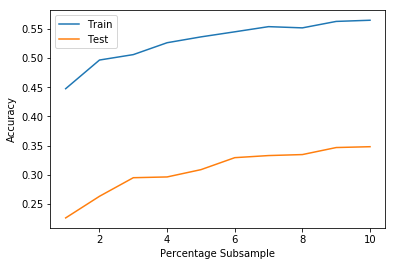

[0.44756256 0.49673033 0.5060439  0.52644716 0.53645695 0.54515821
 0.55402916 0.55193177 0.56300116 0.56501519]


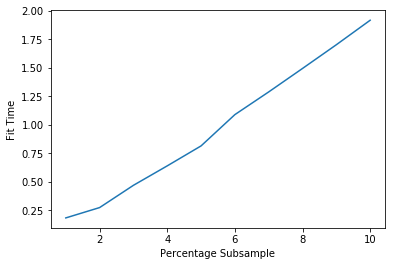

In [6]:
#Line graph accuracy train KNN
plt.plot(range(1,11), all_accuracy_train_KNN, label = 'Train' )
plt.plot(range(1,11), all_accuracy_test_KNN, label = 'Test' )
plt.ylabel('Accuracy')
plt.xlabel('Percentage Subsample')
plt.legend()
plt.show()
print(all_accuracy_train_KNN )
print(all_accuracy_test_KNN)

plt.plot(range(1,11), all_fit_time_KNN)
plt.ylabel('Fit Time')
plt.xlabel('Percentage Subsample')
plt.show()

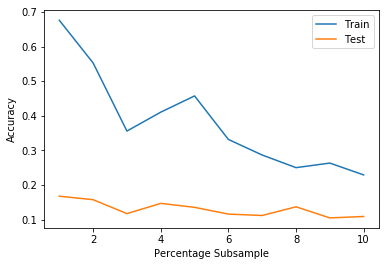

[0.6760179  0.55264262 0.35575487 0.41041929 0.45730931 0.33151204
 0.28649765 0.25003945 0.26322537 0.22904698]


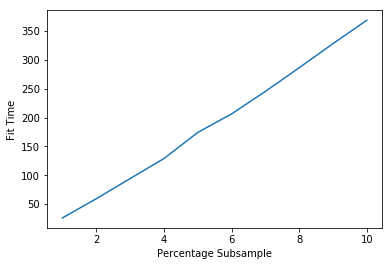

In [7]:
#Line graph accuracy train linear regression
#Second run

plt.plot(range(1,11), all_accuracy_train_linear, label = 'Train')
plt.plot(range(1,11), all_accuracy_test_linear, label = 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Percentage Subsample')
plt.legend()
plt.show()
print(all_accuracy_train_linear)

plt.plot(range(1,11), all_fit_time_linear)
plt.ylabel('Fit Time')
plt.xlabel('Percentage Subsample')
plt.show()

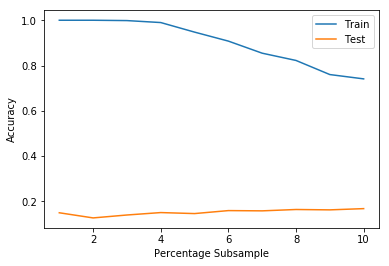

[1.         1.         0.99848765 0.98980541 0.94752635 0.90775865
 0.85438914 0.82229571 0.75996221 0.74088155]


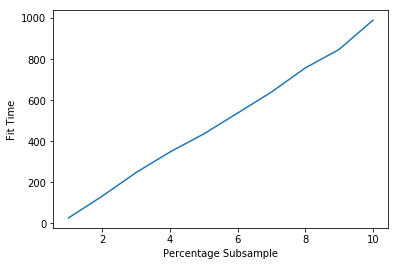

In [8]:
#Line graph accuracy train logistic regression
plt.plot(range(1,11), all_accuracy_train_logistic, label = 'Train')
plt.plot(range(1,11), all_accuracy_test_logistic, label = 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Percentage Subsample')
plt.legend()
plt.show()
print(all_accuracy_train_logistic)

plt.plot(range(1,11), all_fit_time_logistic)
plt.ylabel('Fit Time')
plt.xlabel('Percentage Subsample')
plt.show()

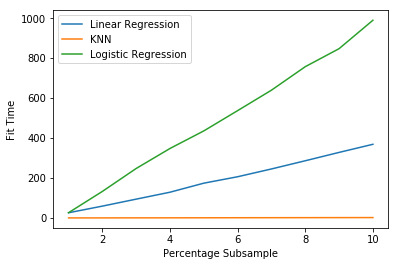

In [11]:
#Plot all fit time together:
plt.plot(range(1,11), all_fit_time_linear, label='Linear Regression')
plt.plot(range(1,11), all_fit_time_KNN, label = 'KNN' )
plt.plot(range(1,11), all_fit_time_logistic, label = 'Logistic Regression')
plt.ylabel('Fit Time')
plt.xlabel('Percentage Subsample')
plt.legend()
plt.show()

## Interpretations:

### Performance:
The performance of the training data, measured by accuracy, of the three models is distinctively different. As can be seen in the line graph of the accuracy, the logistic regression performs best.  

#### KNN
From the graphs there can be concluded that the train and test accuracy increase when the size of the training data increases. This can be argued by the fact that when the size of the training data becomes bigger, the sample where the model is fitted on reflects the population better. Which has to do with the training data being smaller, the more influence outliers and extreme values have on the model. The training accuracy of the KNN is at its maximum at 56.5%, for 10% sample and at its lowest is 44.8% for a 1% sample. This accuracy is low since it classifies just over half of the cases correctly. When the train and test accuracy are compared there can be concluded that the test accuracy is lower, at its highest point around 35%. This is low and there can be concluded that the model is underfitting due to the training and test accuracy both being low. The amount of neighbours can therefore be decreased to diminish the effect of underfitting and let the algorithm consider less neighbours to classify cases. Since, as can be seen in the graph, the training score is still increasing, more data would benefit this model.

#### Linear SVM
From the graphs there can be concluded that the training accuracy drops when increasing the training size. Nevertheless there is a remarkable drop at a training size of 5%. When the test accuracy is considered, it becomes clear that the model is very poor. The test accuracy does not exceed 20%. There can also be concluded that at a sample of 1% the model is overfitting and later on starts underfitting but the model stays poor for predicting purposes having a very low test accuracy. 

#### Logistic Regression
From the graphs there can be concluded that the model is heavily overfitting at the start having a training accuracy of 100% and test accuracy of more or less 15%. As the sample increases the training accuracy decreases and the test accuracy increases a little bit. Nevertheless, the model is still overfitting due to having a very high training accuracy and low test accuracy. To conclude, by looking at the accuracy there can be stated that the model is very poor and correctly classifies at its highest point nearly 20% of the cases correctly.
Note: As solver liblinear is used, we tried lbfgs with multiclass: multinomial, we tried this since the class variable is not binary but categorical with more than two categories. Nevertheless, this model did not converge. Increasing the iterations to 1000 or even 1500 did not help and other solutions as normalization of the data was not part of the exercise. Another possible fix could be adding more data. Therefore we interpreted the results of logistic regression with as solver liblinear. Since, as can be seen in the graph, the training score is still increasing, more data would benefit this model. 

#### Accuracy comparison
To conclude, all models show poor results in means of predictive value. KNN performs the best taking into account the training and test accuracy. It has the best test accuracy being around twice as high as both other models. Next to that there can be stated that there is a trend in increasing test accuracy as the training sample increases. For linear svm, this is not necesarraly the case since the test accuracy is very low and 

###  Running time:
The models, created with KNN, linear regression, and logistic regression, have the same trend. They all tend to be almost linear. At a 1% sample is the lowest point and the fit time gradually increases when the percentage of amount of data increases. Intuitively, it is expected that the running time of the training set will increase if you add more data, since it has to train the model on more data.    

#### KNN
As can be seen in the line graph, containing the fit-times from all the classifiers, the KNN has the lowest training fit-time. A possible reason for this is that KNN uses a lazy algorithm. This means that the algorithm does not need training (many) data points for model generation. This leads to fast training fit-time and a higher running time. Nevertheless, the fit-time follows a similar trend like the other classifiers, just with a lower running time.

#### Linear Regression
The second fastest model, considering training fit-time, is linear regression. Just like the two other models, the lowest training time is at 1% stratisfied sample of the entire dataset. 

#### Logistic Regression
The model with the slowest training time is the logistic regression. It follows the same trend as the other models, but the trend line is much steeper. 

## 3. Data representation (20 points) {-}
* Convert the images to grayscale (use the function below). Check whether the conversion is correct by plotting a few of the converted images.
    * Is the grayscale representation better than the color representation? Does it yield better models? Why (not)? Run the necessary experiments and discuss. For instance, compare the performance of models trained on both representations.
* Afterwards, standardize the data by substracting the mean of the pixel values from every image and dividing by the standard deviation of very image. 
    * Note: Do this for every image independently. Don't compute means or standard deviations over the entire training/test set
    * Again, check whether you have done it correctly by plotting some of the converted images.
    * Is the new representation better? Why (not)? Run the necessary experiments and discuss.
* Finally, run [PCA (Principal Component Analysis)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the data and see if that gives you a better (lower-dimensional) representation. Note that you need to use a pipeline here to avoid data leakage between your training and test set (see Tutorial 3).
    * Try different numbers of components or use a solver to guess the optimal number of components
    * Is the new representation better? Why (not)? Run the necessary experiments and discuss.

### GRAY

In [6]:
# Converts an RGB encoded image to a grayscale image
def rgb2gray(X, dim=32):
    return np.expand_dims(np.dot(X.reshape(len(X), dim*dim, 3), [0.2990, 0.5870, 0.1140]), axis=3)
X_gray = rgb2gray(X)

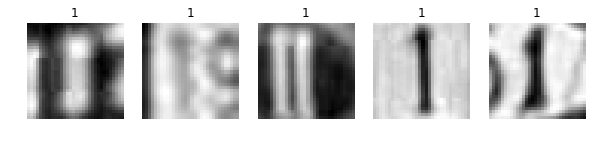

In [55]:
plot_images(X_gray[0:5], y[0:5], grayscale=True) 

The conversion is correct because the same images and classes as depicted in cell 3 are shown. They look exaclty the same except for the colour. 

In [18]:
flat_x_gray = [img.flatten() for img in X_gray]
X_gray_sample = [flat_x_gray[idx] for idx in sample10idx]
CV_knn_gray= sklearn.model_selection.cross_validate(KNN, X_gray_sample, sample_y, cv=3, return_train_score=True)

In [20]:
print('train_accuracy: ', CV_knn_gray['train_score'].mean() )
print('train_std: ' ,CV_knn_gray['train_score'].std() )
print('test_accuracy: ' ,CV_knn_gray['test_score'].mean() ) 
print('test_std: ' ,CV_knn_gray['test_score'].std() )

train_accuracy:  0.5776006177333953
train_std:  0.0009291183557151172
test_accuracy:  0.3745614490737941
test_std:  0.004130915175920441


#### Evaluation KNN 
If we compare the train and test accuracy of the KNN on the colour representation (train_accuracy = 0.56 and test_accuracy = 0.36) and the KNN on grayscale representation (train_accuracy = 0.58 and test_accuracy = 0.37), very little differences can be found. Therefore we can conclude that the grayscale representation does not improve the performance of the model meausured in accuracy. 



In [45]:
CV_lr_gray = sklearn.model_selection.cross_validate(lr, 
                                               X_gray_sample, 
                                               sample_y, 
                                               cv=3, 
                                               return_train_score=True, 
                                               scoring='accuracy')

In [22]:
print('train_accuracy: ', CV_lr_gray['train_score'].mean() )
print('train_std: ' ,CV_lr_gray['train_score'].std() )
print('test_accuracy: ' ,CV_lr_gray['test_score'].mean() ) 
print('test_std: ' ,CV_lr_gray['test_score'].std() )

train_accuracy:  0.5138020403437892
train_std:  0.01172843048876769
test_accuracy:  0.17524494302432958
test_std:  0.0031297945315506


#### Evaluation Logistic Regression 
In this case, the train accuracy of the model decreases notably (train_accuracy colour = 0.75 and train_accuracy gray = 0.52). The test acuracies stay relatively similar and low (test_accuracy colour = 0.17 and test_accuracy gray = 0.18) indicating that both models fail to generalise. Thus, we can conclude that the model does not perform better.

In [46]:
CV_svm_gray = sklearn.model_selection.cross_validate(svm, X_gray_sample, sample_y, cv=3, return_train_score=True, scoring='accuracy')

In [24]:
print('train_accuracy: ', CV_svm_gray['train_score'].mean() )
print('train_std: ' ,CV_svm_gray['train_score'].std() )
print('test_accuracy: ' ,CV_svm_gray['test_score'].mean() ) 
print('test_std: ' ,CV_svm_gray['test_score'].std() )

train_accuracy:  0.22360830680336305
train_std:  0.05885588010088494
test_accuracy:  0.1367537322799506
test_std:  0.02346673391674242


#### Evaluation SVM
If we compare the train and test accuracy of the KNN on the colour representation (train_accuracy = 0.25 and test_accuracy = 0.13) and the KNN on grayscale representation (train_accuracy = 0.18 and test_accuracy = 0.13), the train score of the colour representation is higher than the train score of the gray scale representation while the test score remain the same. Considering the test scores, we can conclude that the grayscale representation does not improve the performance of the model meausured in accuracy. 

### GRAY NORMALIZED

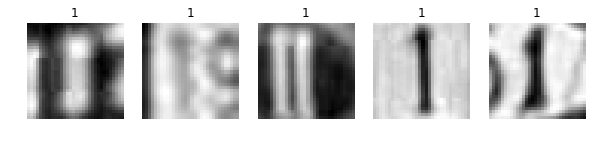

In [25]:
X_gray_norm = [(img-img.mean())/img.std() for img in X_gray]


plot_images(X_gray_norm[0:5], y[0:5], grayscale=True)

Again, the conversion is correct because the same images and classes as depicted in cell 3 are shown. They look exaclty the same except for the colour. 

In [26]:
flat_x_gray_norm = [img.flatten() for img in X_gray_norm]
X_gray_norm_sample = [flat_x_gray_norm[idx] for idx in sample10idx]
CV_knn_gray_norm= sklearn.model_selection.cross_validate(KNN, X_gray_norm_sample, sample_y, cv=3, return_train_score=True)

In [28]:
print('train_accuracy: ', CV_knn_gray_norm['train_score'].mean() )
print('train_std: ' ,CV_knn_gray_norm['train_score'].std() )
print('test_accuracy: ' ,CV_knn_gray_norm['test_score'].mean() ) 
print('test_std: ' ,CV_knn_gray_norm['test_score'].std() )

train_accuracy:  0.694629854411211
train_std:  0.005856455663045474
test_accuracy:  0.5384185433165573
test_std:  0.0064579691243896575


The normalized gray represenation yields a notably better model (train_accuracy = 0.69 and test_accuracy = 0.54) than the colour represenatation as well as the gray representation mentioned above. This model succeeds a lot better in generalizing, thus we can conclude that the normalized representation yields a better KNN classifier model.

In [47]:
CV_lr_gray_norm = sklearn.model_selection.cross_validate(lr, X_gray_norm_sample, sample_y, cv=3, return_train_score=True, scoring='accuracy')

In [30]:
print('train_accuracy: ', CV_lr_gray_norm['train_score'].mean() )
print('train_std: ' ,CV_lr_gray_norm['train_score'].std() )
print('test_accuracy: ' ,CV_lr_gray_norm['test_score'].mean() ) 
print('test_std: ' ,CV_lr_gray_norm['test_score'].std() )

train_accuracy:  0.4682748530362553
train_std:  0.0034370251974818007
test_accuracy:  0.20908461802140213
test_std:  0.001964873446604969


The normalized gray representation yields slightly better models for logistic regression than the gray and colour representation, because the testscore is slightly better (0.21 compared to 0.17 and 0.18). However, the difference is nog major.

In [48]:
CV_svm_gray_norm = sklearn.model_selection.cross_validate(svm, X_gray_norm_sample, sample_y, cv=3, return_train_score=True, scoring='accuracy')

In [32]:
print('train_accuracy: ', CV_svm_gray_norm['train_score'].mean() )
print('train_std: ' ,CV_svm_gray_norm['train_score'].std() )
print('test_accuracy: ' ,CV_svm_gray_norm['test_score'].mean() ) 
print('test_std: ' ,CV_svm_gray_norm['test_score'].std() )

train_accuracy:  0.346411246047253
train_std:  0.0052011852978139875
test_accuracy:  0.14895512722376025
test_std:  0.004193258265063524


The normalized gray representation yields slightly better models for logistic regression than the gray and colour representation, because the testscore is slightly better (0.21 compared to 0.17 and 0.18). However, the difference is small.

In [48]:
CV_svm_gray_norm = sklearn.model_selection.cross_validate(svm, X_gray_norm_sample, sample_y, cv=3, return_train_score=True, scoring='accuracy')

In [32]:
print('train_accuracy: ', CV_svm_gray_norm['train_score'].mean() )
print('train_std: ' ,CV_svm_gray_norm['train_score'].std() )
print('test_accuracy: ' ,CV_svm_gray_norm['test_score'].mean() ) 
print('test_std: ' ,CV_svm_gray_norm['test_score'].std() )

train_accuracy:  0.346411246047253
train_std:  0.0052011852978139875
test_accuracy:  0.14895512722376025
test_std:  0.004193258265063524


The normalized gray representation yields slightly better models for support vector machine than the gray and colour representation, the test score is slightly better (0.16 compared to 0.13 and 0.13). Here, again, the improvement is very small.

### Principal Component Analysis

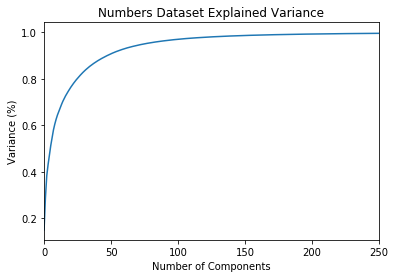

In [33]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_gray_norm_sample)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.xlim(0, 250)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Numbers Dataset Explained Variance')
plt.show()

Based on the above plot, we decided to test for a range from 20 to 150 components using steps of 10, since there is still a lot of variance added by using more components between 20 and 150 components. 

In [34]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_gray_norm_sample, sample_y, test_size=0.25, stratify=sample_y, random_state=1)
params = {'pca__n_components': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}

In [35]:
pipe_knn = Pipeline([("pca", PCA()), ("knn", KNN)])

In [36]:
print('K Nearest Neighbors')
create_grid_knn = GridSearchCV(pipe_knn, param_grid=params, cv=3)
create_grid_knn.fit(X_train, Y_train)
print('train_score: ', create_grid_knn.score(X_train, Y_train))
print('test_score: ', create_grid_knn.score(X_test, Y_test))
print(create_grid_knn.best_params_)

K Nearest Neighbors
train_score:  0.7160891753961859
test_score:  0.5521546516310915
{'pca__n_components': 60}


The PCA representation with 60 components yields a slightly better KNN model than the normalized gray representation with train_accuracy = 0.69 and test_accuracy = 0.54 for the normalized gray representation and train_accuracy = 0.71 and test_accuracy = 0.57 for the PCA representation. Both the train score and the test score are better for the PCA representation. However, the increase in test score, is nog major. 

In [38]:
pipe_lr = Pipeline([("pca", PCA()), ("lr", lr)])

In [49]:
print('Logistic Regression')
create_grid_lr = GridSearchCV(pipe_lr, param_grid=params, cv=3)
create_grid_lr.fit(X_train, Y_train)
print('train_score: ', create_grid_lr.score(X_train, Y_train))
print('test_score: ', create_grid_lr.score(X_test, Y_test))
print(create_grid_lr.best_params_)

Logistic Regression
train_score:  0.27571850658071445
test_score:  0.2593636729762384
{'pca__n_components': 40}


The PCA representation with 50 component is better in generalizing, compared to all the other representation with a test score of 0.27 comapared to a test score of 0.21 for the normalized gray scale representation and even lower test scores for the other representations. 

In [40]:
pipe_svm = Pipeline([("pca", PCA()), ("svm", svm)])

In [50]:
print('Support Vector Machinne')
create_grid_svm = GridSearchCV(pipe_svm, param_grid=params, cv=3)
create_grid_svm.fit(X_train, Y_train)
print('train_score: ', create_grid_svm.score(X_train, Y_train))
print('test_score: ', create_grid_svm.score(X_test, Y_test))
print(create_grid_svm.best_params_)

Support Vector Machinne
train_score:  0.16653236637120603
test_score:  0.14941602899718082
{'pca__n_components': 110}


The PCA representation with 100 componenst (train_accuracy = 0.16 and test_accuracy = 0.13) performs worse on both the training and the test scores compared to the normalized gray representation (train_accuracy = 0.36 and test_accuracy = 0.16), thus it does not yield a better model. However, again, the difference is small.

## 4. Regularization (20 points) {-}
- Tune the algorithm's main regularization hyperparameter on the 10% stratified subsample using the standardized grayscale representation. These are the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. 
- We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. C should be varied logarithmically, n_neighbors linearly. 
- Run a grid search over these ranges, using 3-fold cross-valdation, and plot both the training and test error. Start with a coarse grid (e.g. 5 values per hyperparameter), use a finer grid for the 'interesting' regions (where performance changes) if training time allows.
- Plot the effect of every one of the hyperparameters (both the training and test score). Discuss the plots. For which values is the model over/underfitting? Is there a sweet spot?
- Evaluate the optimized models (the best hyperparameter settings) on the rest of the (unseen) data and discuss your findings. Do the results generalize? If not, what can/ should you do? Discuss. Run additional experiments if it helps you confirm your claims.

### Setup
For this part we took a 10% sample of the total dataset and split this into a validation set, a training set and a test set of respectively 35%, 35% and 30%. Next we ran a coarse gridsearch and made a visualization of the results. Based on these plots we defined a finer grid and did another gridsearch, leading to a "peak" in the test_score, indicating the optimal hyperparameter.

Both linear models gave a test score between 20% and 24% accuracy. The non-parametrical kNN model gave a much higher test score of almost 50%.

Given the long runtimes we were not able to run the model on the full dataset to validate the findings on the 10% stratified sample.

In [196]:
X_train_temp, X_test, y_train_temp, y_test = sklearn.model_selection.train_test_split(X_gray_norm_sample, sample_y, test_size=0.30, stratify=sample_y, random_state=1)
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(X_train_temp, y_train_temp, test_size=0.50, stratify=y_train_temp, random_state=1)

### SVM hyperparameter optimization

In [ ]:
#Tuning C for SVM
svc_grid_coarse = {'C': [10e-12, 10e-6, 10e0, 10e6, 10e12]} #Create the coarse grid
svc_grid_search_coarse = GridSearchCV(LinearSVC(), svc_grid_coarse, cv = 3) #Create gridsearchcv object
svc_grid_search_coarse.fit(X_validate, y_validate)
svc_coarse_end = time.time()

In [393]:
print("Best score: {}".format(svc_grid_search_coarse.best_score_))
print("Best value for C: {}".format(svc_grid_search_coarse.best_params_))

Best score: 0.19942446043165468
Best value for C: {'C': 1e-05}


In [204]:
#saving the model for future use
dump(svc_grid_search_coarse, 'svc_grid_search_coarse.joblib');

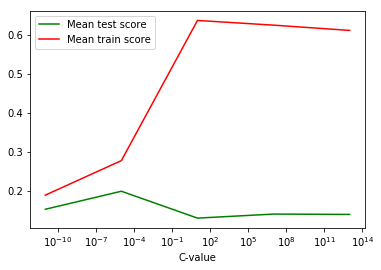

In [353]:
plt.semilogx(svc_grid_search_coarse.cv_results_['param_C'], svc_grid_search_coarse.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score')
plt.semilogx(svc_grid_search_coarse.cv_results_['param_C'], svc_grid_search_coarse.cv_results_['mean_train_score'], color = 'red', label = 'Mean train score')
plt.xlabel('C-value')
plt.legend()
plt.show()

In [355]:
#Tuning C further for SVM
svc_grid_fine = {'C': [10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1]}
svc_grid_search_fine = GridSearchCV(LinearSVC(), svc_grid_fine, cv = 3)
svc_grid_search_fine.fit(X_validate, y_validate) 

In [395]:
print("Best score: {}".format(svc_grid_search_fine.best_score_))
print("Best C: {}".format(svc_grid_search_fine.best_params_))

Best score: 0.221294964028777
Best C: {'C': 0.0001}


In [357]:
#saving the model for future use
dump(svc_grid_search_fine, 'svc_grid_search_fine.joblib');

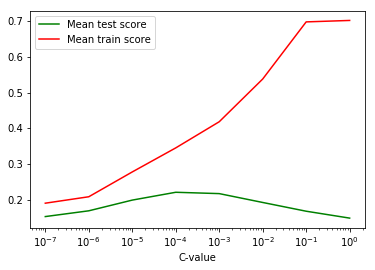

In [359]:
plt.semilogx(svc_grid_search_fine.cv_results_['param_C'], svc_grid_search_fine.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score')
plt.semilogx(svc_grid_search_fine.cv_results_['param_C'], svc_grid_search_fine.cv_results_['mean_train_score'], color = 'red', label = 'Mean train score')
plt.xlabel('C-value')
plt.legend()
plt.show()

There can be concluded that the model is heavily underfitting when C is low (10^-7), it namely has a very low training and test accuracy. On the other hand it is heavily overfitting when the C parameter is high (10). The sweet spot can be found in between where there is a less strong effect of  over and under-fitting. The sweet point for this model lays at 10^-4 - 10^-3. The test accuracy is at at its best with this parameter setting but is still very low, namely between 20 and 25%. To conclude, if the parameter C has a large value and with that a small margin, the model tends to overfit and when it has a small value and large margin it tends to underfit.

In [361]:
SVC_final_model = LinearSVC(C=0.0001)
SVC_final_model.fit(X_train, y_train);

In [362]:
#saving the model for future use
dump(SVC_final_model, 'SVC_final_model.joblib');

In [363]:
#Look at model accuracy
print("Train score: {}".format(SVC_final_model.score(X_train, y_train)))

#Look at model accuracy
print("Test score: {}".format(SVC_final_model.score(X_test, y_test)))

Train score: 0.31712230215827336
Test score: 0.22625041960389392


### Logistic Regression hyperparameter optimization

In [364]:
#Tuning C for Logistic Regression
lr_grid_coarse = {'C': [10e-12, 10e-6, 10, 10e6, 10e12]} #Create the coarse grid
lr_grid_search_coarse = GridSearchCV(LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', n_jobs = -1), lr_grid_coarse, cv = 3) #Create gridsearchcv object
lr_grid_search_coarse.fit(X_validate, y_validate) 

In [397]:
print("Best score: {}".format(lr_grid_search_coarse.best_score_))
print("Best C: {}".format(lr_grid_search_coarse.best_params_))

Best score: 0.1910791366906475
Best C: {'C': 1e-11}


In [366]:
#saving the model for future use
dump(lr_grid_search_coarse, 'lr_grid_search_coarse.joblib');

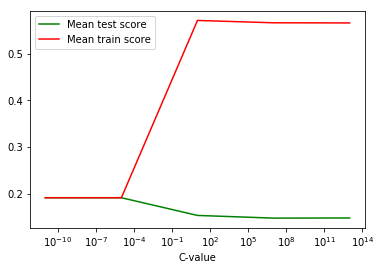

In [368]:
plt.semilogx(lr_grid_search_coarse.cv_results_['param_C'], lr_grid_search_coarse.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score')
plt.semilogx(lr_grid_search_coarse.cv_results_['param_C'], lr_grid_search_coarse.cv_results_['mean_train_score'], color = 'red', label = 'Mean train score')
plt.xlabel('C-value')
plt.legend()
plt.show()

In [369]:
#Tuning C further for Logistic Regression
lr_grid_fine = {'C': [10e-9, 10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2]} #Create the coarse grid
lr_grid_search_fine = GridSearchCV(LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', n_jobs = -1), lr_grid_fine, cv = 3) #Create gridsearchcv object
lr_grid_search_fine.fit(X_validate, y_validate)

In [399]:
print("Best score: {}".format(lr_grid_search_fine.best_score_))
print("Best C: {}".format(lr_grid_search_fine.best_params_))

Best score: 0.23971223021582733
Best C: {'C': 0.001}


In [371]:
#saving the model for future use
dump(lr_grid_search_fine, 'lr_grid_search_fine.joblib');

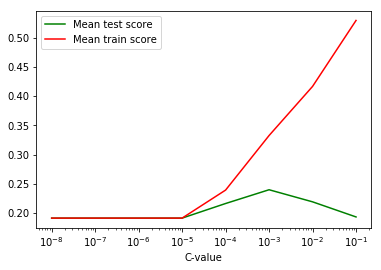

In [373]:
plt.semilogx(lr_grid_search_fine.cv_results_['param_C'], lr_grid_search_fine.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score')
plt.semilogx(lr_grid_search_fine.cv_results_['param_C'], lr_grid_search_fine.cv_results_['mean_train_score'], color = 'red', label = 'Mean train score')
plt.xlabel('C-value')
plt.legend()
plt.show()

By tuning the regularization parameter of logistic regression, the following can be concluded. The model is heavily overfitting when C is high, which can be argued by the fact that the regularization is low. When the value of C becomes lower, the regularization increases and regulates against overfitting. At a certain point (C=10^-3) the regularization becomes to much and starts to decrease the test score. At C=10^-3 a sweet spot can be identified. However, the test score and training accuracy are not good since the test accuracy is around 25% and training score is around 35%.

In [374]:
LR_final_model = LogisticRegression(C=0.001);
LR_final_model.fit(X_train, y_train);

In [375]:
#saving the model for future use
dump(LR_final_model, 'LR_final_model.joblib');

In [404]:
#Look at model accuracy
print("Train score: {}".format(LR_final_model.score(X_train, y_train)))

#Look at model accuracy
print("Test score: {}".format(LR_final_model.score(X_test, y_test)))

Train score: 0.299568345323741
Test score: 0.2373279624034911


### KNN hyperparameter optimization


In [244]:
#Tuning Number of Neighbors for KNN
knn_grid_coarse = {'n_neighbors': [1,10,20,30,40,50]} #Create the grid
knn_grid_search_coarse = GridSearchCV(KNeighborsClassifier(n_jobs = -1), knn_grid_coarse, cv = 3) #Create gridsearchcv object
knn_grid_search_coarse.fit(X_validate, y_validate)

In [405]:
print("Best score: {}".format(knn_grid_search_coarse.best_score_))
print("Best number of neighbors: {}".format(knn_grid_search_coarse.best_params_))

Best score: 0.4935251798561151
Best number of neighbors: {'n_neighbors': 20}


In [246]:
#saving the model for future use
dump(knn_grid_search_coarse, 'knn_grid_search_coarse.joblib');

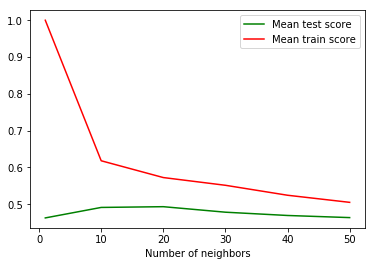

In [248]:
plt.plot(knn_grid_search_coarse.cv_results_['param_n_neighbors'], knn_grid_search_coarse.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score')
plt.plot(knn_grid_search_coarse.cv_results_['param_n_neighbors'], knn_grid_search_coarse.cv_results_['mean_train_score'], color = 'red', label = 'Mean train score')
plt.xlabel('Number of neighbors')
plt.legend()
plt.show()

In [249]:
knn_grid_fine = {'n_neighbors': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]} #Create the grid
knn_grid_search_fine = GridSearchCV(KNeighborsClassifier(n_jobs = -1), knn_grid_fine, cv = 3) #Create gridsearchcv object
knn_grid_search_fine.fit(X_validate, y_validate)

In [407]:
print("Best score: {}".format(knn_grid_search_fine.best_score_))
print("Best number of neighbors: {}".format(knn_grid_search_fine.best_params_))

Best score: 0.4992805755395684
Best number of neighbors: {'n_neighbors': 12}


In [251]:
#saving the model for future use
dump(knn_grid_search_fine, 'knn_grid_search_fine.joblib');

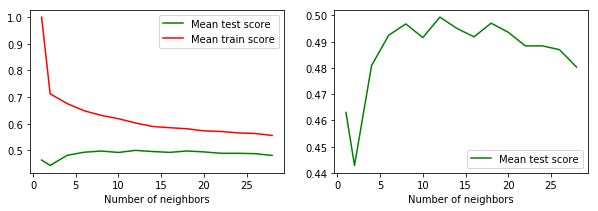

In [421]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axes[0].plot(knn_grid_search_fine.cv_results_['param_n_neighbors'], knn_grid_search_fine.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score');
axes[0].plot(knn_grid_search_fine.cv_results_['param_n_neighbors'], knn_grid_search_fine.cv_results_['mean_train_score'], color = 'red', label = 'Mean train score');
axes[0].legend();
axes[0].set_xlabel('Number of neighbors');

axes[1].plot(knn_grid_search_fine.cv_results_['param_n_neighbors'], knn_grid_search_fine.cv_results_['mean_test_score'], color = 'green', label = 'Mean test score');
axes[1].legend();
axes[1].set_xlabel('Number of neighbors');

The model is heavily overfitting when K=1 since it is being very specifically looking at one neighbour per class. As the amount of neighbours increases, the model does not tend to overfit anymore. The sweet spot of this model lays at 12 neighbours where the test accuracy on its best and the model is not overfitting anymore.

In [305]:
KNN_final_model = KNeighborsClassifier(n_neighbors=12, n_jobs = -1);
KNN_final_model.fit(X_train, y_train);

In [306]:
#saving the model for future use
dump(KNN_final_model, 'KNN_final_model.joblib');

In [307]:
#Look at model accuracy
print("Train score: {}".format(KNN_final_model.score(X_train, y_train)))

#Look at model accuracy
print("Test score: {}".format(KNN_final_model.score(X_test, y_test)))

Train score: 0.6106474820143885
Test score: 0.5001678415575697


## 5. Interpreting misclassifications (10 points) {-}
- Chances are that your best model is not 100% accurate. Plot a few of the misclassified examples and their predicted and correct labels. Discuss. Are these indeed 'hard' examples that are easy to get wrong?

In [90]:
SVC_final_model1 = load('SVC_final_model.joblib') 

In [139]:
y_test = np.asarray(y_test)
misclassified = np.where(y_test != SVC_final_model1.predict(X_test))

In [126]:
#Create a list with all predictions where the misclassified samples are displayed by either True or False
all_predictions = [[i, predictions[i], y_test[i], (predictions[i]== y_test[i]) ] for i in range(len(y_test))]

#Create two lists with the testing data if the (x,y) is misclassified 
testing_data_x = [X_test[i] for i in range(len(X_test)) if all_predictions[i][3] == False]
testing_data_y = [all_predictions[i][1] for i in range(len(X_test)) if all_predictions[i][3] == False]

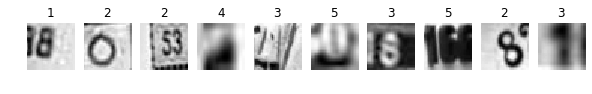

In [138]:
#Plot some of the misclassified samples
plot_images(testing_data_x[:10], testing_data_y[:10], grayscale=True)

### Interpretations misclassifications
Most of the misclassified examples are indeed hard to predict. As can be seen in the series of images above, the fourth, fifth, sixth are clearly hard to predict since the images are very pixelated or blurry. In addition to this, some of the numbers are depicted very close to each other or are skewed, making them hard to predict. 

- Plot the confusion matrix. Which digits are often confused with each other? Which digits are easier/harder to classify? Discuss.

Confusion matrix, without normalization


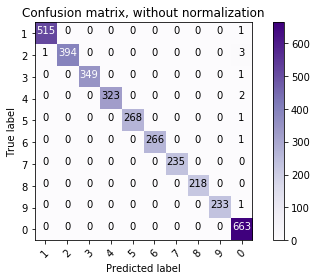

In [149]:
from sklearn.metrics import confusion_matrix
best_y_pred_train = SVC_final_model1.predict(X_train)

#print(confusion_matrix(y_train, best_y_pred))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

############ CONFUSION MATRIX: TRAIN DATA

cnf_matrix = confusion_matrix(y_train, best_y_pred,labels=[1,2,3,4,5,6,7,8,9,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5','6','7','8','9','0'],
                      title='Confusion matrix, without normalization')


Confusion matrix, without normalization


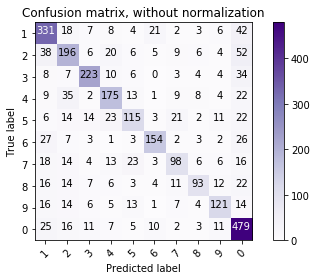

In [150]:
############ CONFUSION MATRIX: TEST DATA

best_y_pred_test = SVC_final_model1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, best_y_pred_test,labels=[1,2,3,4,5,6,7,8,9,0]);
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5','6','7','8','9','0'],
                      title='Confusion matrix, without normalization')

## Interpretation confusion matrices
First there will be looked at which digitis are often confused with each other. 

The first remarkable point is that all digits are relativly often falsely classified as number 1 and 0. For digit 1 this can be argued by the fact that 1 has the most simple form, mainly existing out of one vertical line which therefore can be confused more easily than the less simple shapes of the other digits. For digit 0 it can be explained by the simple round form, many numbers also have a round form (3,5,6,8,9) and can therefore easy be confused with 0. 

If we look at the top 10 of most confused digits, the confusion matrix states the following:

1.  2 classified as 0: 52 cases
2.  1 classified as 0: 42 cases
3.  2 classified as 1: 38 cases
4.  4 classified as 2: 35 cases
5.  3 classified as 0: 34 cases
6.  6 classified as 2: 27 cases
7.  6 classified as 0: 26 cases
8.  0 classified as 1: 25 cases
9.  7 classified as 5: 23 cases
10. 4 classified as 0: 22 cases
10. 5 classified as 0: 22 cases
10. 8 classified as 0: 22 cases

Every number in the top 10 most missclassified, is missclassified as a 0. There can be concluded that digits are easily confused with 0. 
Next we look at the ratio per digit at which it is classified correctly/classified falsely. These ratio's give more insight on thow easy/hard a certain digit can be classified correctly.
    F      T    (F/(F+T))
0:  90  v 479 = 15.8% 
9:  80  v 121 = 39.8% 
8:  95  v  93 = 50.5%
7: 103  v  98 = 51.2%
6:  74  v 154 = 32.5%
5: 116  v 115 = 50.2%
4: 103  v 175 = 37.1%
3:  76  v 223 = 25.4%
2: 146  v 196 = 42.6%
1: 111  v 331 = 25.1%

From these ratios there can be concluded that number 5,7,8 are relatively most often missclassified, each number is missclassified as another digit in just over 50% of the cases. The digits 0, 1 and 3 are relatively least often missclassified 0: 15.8% and 2,3 around 25%. 

We can conclude that digits are most often missclassified as a 0, 2 or 1. These numbers are therefore assumed to be most similar in looks to the other digits. Next, the numbers 0,1 and 3 are classified with the highest accuracy and 5,7, 8 are classified with the lowest accuracy. 
One remarkable point can be made, that digits are often missclassified as 0 or 1 is probably in relation to the number 0 and 1 having a high accuracy since there might be superpixels which occur often and being a significant feature for 0 and 1.




## 6. Interpreting models (15 points) {-}
- Try to understand what the linear models have learned by looking at their model parameters. Are there features (pixels) that are more important than others? What does that tell you?

### Support Vector Machine

In [471]:
print("Class 1 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[0]))))
print("Class 1 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[0]))))

print("Class 2 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[1]))))
print("Class 2 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[1]))))

print("Class 3 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[2]))))
print("Class 3 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[2]))))

print("Class 4 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[3]))))
print("Class 4 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[3]))))

print("Class 5 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[4]))))
print("Class 5 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[4]))))

print("Class 6 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[5]))))
print("Class 6 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[5]))))

print("Class 7 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[6]))))
print("Class 7 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[6]))))

print("Class 8 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[7]))))
print("Class 8 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[7]))))

print("Class 9 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[8]))))
print("Class 9 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[8]))))

print("Class 0 Min: {:.15f}".format(min(abs(SVC_final_model.coef_[9]))))
print("Class 0 Max: {:.15f}\n".format(max(abs(SVC_final_model.coef_[9]))))

Class 1 Min: 0.000001288027686
Class 1 Max: 0.009275567848160

Class 2 Min: 0.000001359401271
Class 2 Max: 0.009347875067030

Class 3 Min: 0.000010660267518
Class 3 Max: 0.007142455149267

Class 4 Min: 0.000002779448988
Class 4 Max: 0.009577854923505

Class 5 Min: 0.000001893438837
Class 5 Max: 0.013273887137532

Class 6 Min: 0.000004905776950
Class 6 Max: 0.009933236277249

Class 7 Min: 0.000003435773597
Class 7 Max: 0.009817854854969

Class 8 Min: 0.000005364036105
Class 8 Max: 0.009439431297959

Class 9 Min: 0.000004363307581
Class 9 Max: 0.009494697665030

Class 0 Min: 0.000003748393045
Class 0 Max: 0.008752494902838



### Logistic Regression

In [377]:
print("Class 1 Min: {:.15f}".format(min(abs(LR_final_model.coef_[0]))))
print("Class 1 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[0]))))

print("Class 2 Min: {:.15f}".format(min(abs(LR_final_model.coef_[1]))))
print("Class 2 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[1]))))

print("Class 3 Min: {:.15f}".format(min(abs(LR_final_model.coef_[2]))))
print("Class 3 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[2]))))

print("Class 4 Min: {:.15f}".format(min(abs(LR_final_model.coef_[3]))))
print("Class 4 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[3]))))

print("Class 5 Min: {:.15f}".format(min(abs(LR_final_model.coef_[4]))))
print("Class 5 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[4]))))

print("Class 6 Min: {:.15f}".format(min(abs(LR_final_model.coef_[5]))))
print("Class 6 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[5]))))

print("Class 7 Min: {:.15f}".format(min(abs(LR_final_model.coef_[6]))))
print("Class 7 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[6]))))

print("Class 8 Min: {:.15f}".format(min(abs(LR_final_model.coef_[7]))))
print("Class 8 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[7]))))

print("Class 9 Min: {:.15f}".format(min(abs(LR_final_model.coef_[8]))))
print("Class 9 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[8]))))

print("Class 0 Min: {:.15f}".format(min(abs(LR_final_model.coef_[9]))))
print("Class 0 Max: {:.15f}\n".format(max(abs(LR_final_model.coef_[9]))))

Class 1 Min: 0.000003721520621
Class 1 Max: 0.007015170686028

Class 2 Min: 0.000000377804986
Class 2 Max: 0.006664458232355

Class 3 Min: 0.000000839912568
Class 3 Max: 0.006046890692605

Class 4 Min: 0.000000408222135
Class 4 Max: 0.008600307120564

Class 5 Min: 0.000006768318714
Class 5 Max: 0.008453826967521

Class 6 Min: 0.000000033370188
Class 6 Max: 0.007585873122720

Class 7 Min: 0.000002112303798
Class 7 Max: 0.006965620486798

Class 8 Min: 0.000000527559856
Class 8 Max: 0.008300752072685

Class 9 Min: 0.000001247773415
Class 9 Max: 0.007917770255251

Class 0 Min: 0.000002690577975
Class 0 Max: 0.008250141602405



We looked at the difference in effects of specific features by picking the largest and smallest absolute value from the weight matrix. This indicates that there are definitely features with large effects relatively to other pixels which states that the model has learned that certain features are more important than others. This is shown visually below.

- Visualize the model parameters of the best (tuned) models as a 32x32 matrix, for each class individually. This means training 10 models in a one-vs-all fashion. Does this help you understand what the model is paying attention to?

### Support Vector Machine

In [472]:
class_1_matrix = SVC_final_model.coef_[0].reshape((32,32))
class_2_matrix = SVC_final_model.coef_[1].reshape((32,32))
class_3_matrix = SVC_final_model.coef_[2].reshape((32,32))
class_4_matrix = SVC_final_model.coef_[3].reshape((32,32))
class_5_matrix = SVC_final_model.coef_[4].reshape((32,32))
class_6_matrix = SVC_final_model.coef_[5].reshape((32,32))
class_7_matrix = SVC_final_model.coef_[6].reshape((32,32))
class_8_matrix = SVC_final_model.coef_[7].reshape((32,32))
class_9_matrix = SVC_final_model.coef_[8].reshape((32,32))
class_0_matrix = SVC_final_model.coef_[9].reshape((32,32))
total_matrix = abs(class_1_matrix) + abs(class_2_matrix) + abs(class_3_matrix) + abs(class_4_matrix) + abs(class_5_matrix) + abs(class_6_matrix) +abs(class_7_matrix) + abs(class_8_matrix) + abs(class_9_matrix) + abs(class_0_matrix)

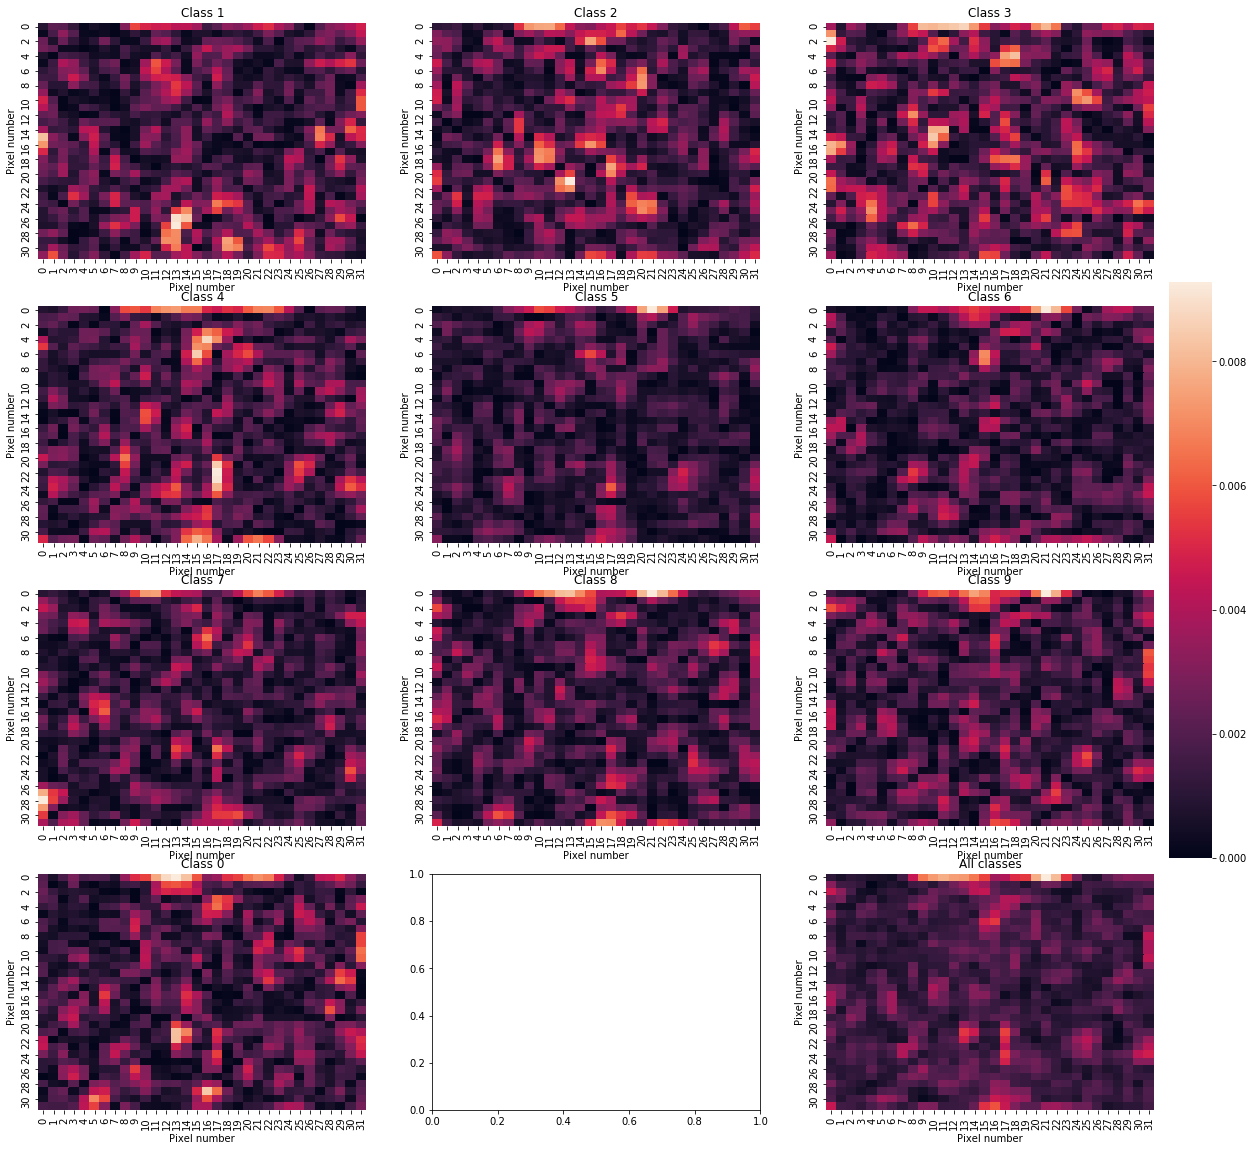

In [473]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20));

heatmap_class_1 = seaborn.heatmap(abs(class_1_matrix), ax=axes[0][0], cbar_ax = fig.add_axes([.91, .3, .03, .4]));
axes[0][0].title.set_text('Class 1')
axes[0][0].set_xlabel('Pixel number')
axes[0][0].set_ylabel('Pixel number')
heatmap_class_2 = seaborn.heatmap(abs(class_2_matrix), ax=axes[0][1], cbar=False);
axes[0][1].title.set_text('Class 2')
axes[0][1].set_xlabel('Pixel number')
axes[0][1].set_ylabel('Pixel number')
heatmap_class_3 = seaborn.heatmap(abs(class_3_matrix), ax=axes[0][2], cbar=False);
axes[0][2].title.set_text('Class 3')
axes[0][2].set_xlabel('Pixel number')
axes[0][2].set_ylabel('Pixel number')
heatmap_class_4 = seaborn.heatmap(abs(class_4_matrix), ax=axes[1][0], cbar=False);
axes[1][0].title.set_text('Class 4')
axes[1][0].set_xlabel('Pixel number')
axes[1][0].set_ylabel('Pixel number')
heatmap_class_5 = seaborn.heatmap(abs(class_5_matrix), ax=axes[1][1], cbar=False);
axes[1][1].title.set_text('Class 5')
axes[1][1].set_xlabel('Pixel number')
axes[1][1].set_ylabel('Pixel number')
heatmap_class_6 = seaborn.heatmap(abs(class_6_matrix), ax=axes[1][2], cbar=False);
axes[1][2].title.set_text('Class 6')
axes[1][2].set_xlabel('Pixel number')
axes[1][2].set_ylabel('Pixel number')
heatmap_class_7 = seaborn.heatmap(abs(class_7_matrix), ax=axes[2][0], cbar=False);
axes[2][0].title.set_text('Class 7')
axes[2][0].set_xlabel('Pixel number')
axes[2][0].set_ylabel('Pixel number')
heatmap_class_8 = seaborn.heatmap(abs(class_8_matrix), ax=axes[2][1], cbar=False);
axes[2][1].title.set_text('Class 8')
axes[2][1].set_xlabel('Pixel number')
axes[2][1].set_ylabel('Pixel number')
heatmap_class_9 = seaborn.heatmap(abs(class_9_matrix), ax=axes[2][2], cbar=False);
axes[2][2].title.set_text('Class 9')
axes[2][2].set_xlabel('Pixel number')
axes[2][2].set_ylabel('Pixel number')
heatmap_class_0 = seaborn.heatmap(abs(class_0_matrix), ax=axes[3][0], cbar=False);
axes[3][0].title.set_text('Class 0')
axes[3][0].set_xlabel('Pixel number')
axes[3][0].set_ylabel('Pixel number')

total_heatmap = seaborn.heatmap(total_matrix, ax=axes[3][2], cbar=False);
axes[3][2].title.set_text('All classes')
axes[3][2].set_xlabel('Pixel number');
axes[3][2].set_ylabel('Pixel number');

The 

### Logistic Regression

In [459]:
class_1_matrix = LR_final_model.coef_[0].reshape((32,32))
class_2_matrix = LR_final_model.coef_[1].reshape((32,32))
class_3_matrix = LR_final_model.coef_[2].reshape((32,32))
class_4_matrix = LR_final_model.coef_[3].reshape((32,32))
class_5_matrix = LR_final_model.coef_[4].reshape((32,32))
class_6_matrix = LR_final_model.coef_[5].reshape((32,32))
class_7_matrix = LR_final_model.coef_[6].reshape((32,32))
class_8_matrix = LR_final_model.coef_[7].reshape((32,32))
class_9_matrix = LR_final_model.coef_[8].reshape((32,32))
class_0_matrix = LR_final_model.coef_[9].reshape((32,32))
total_matrix = abs(class_1_matrix) + abs(class_2_matrix) + abs(class_3_matrix) + abs(class_4_matrix) + abs(class_5_matrix) + abs(class_6_matrix) +abs(class_7_matrix) + abs(class_8_matrix) + abs(class_9_matrix) + abs(class_0_matrix)

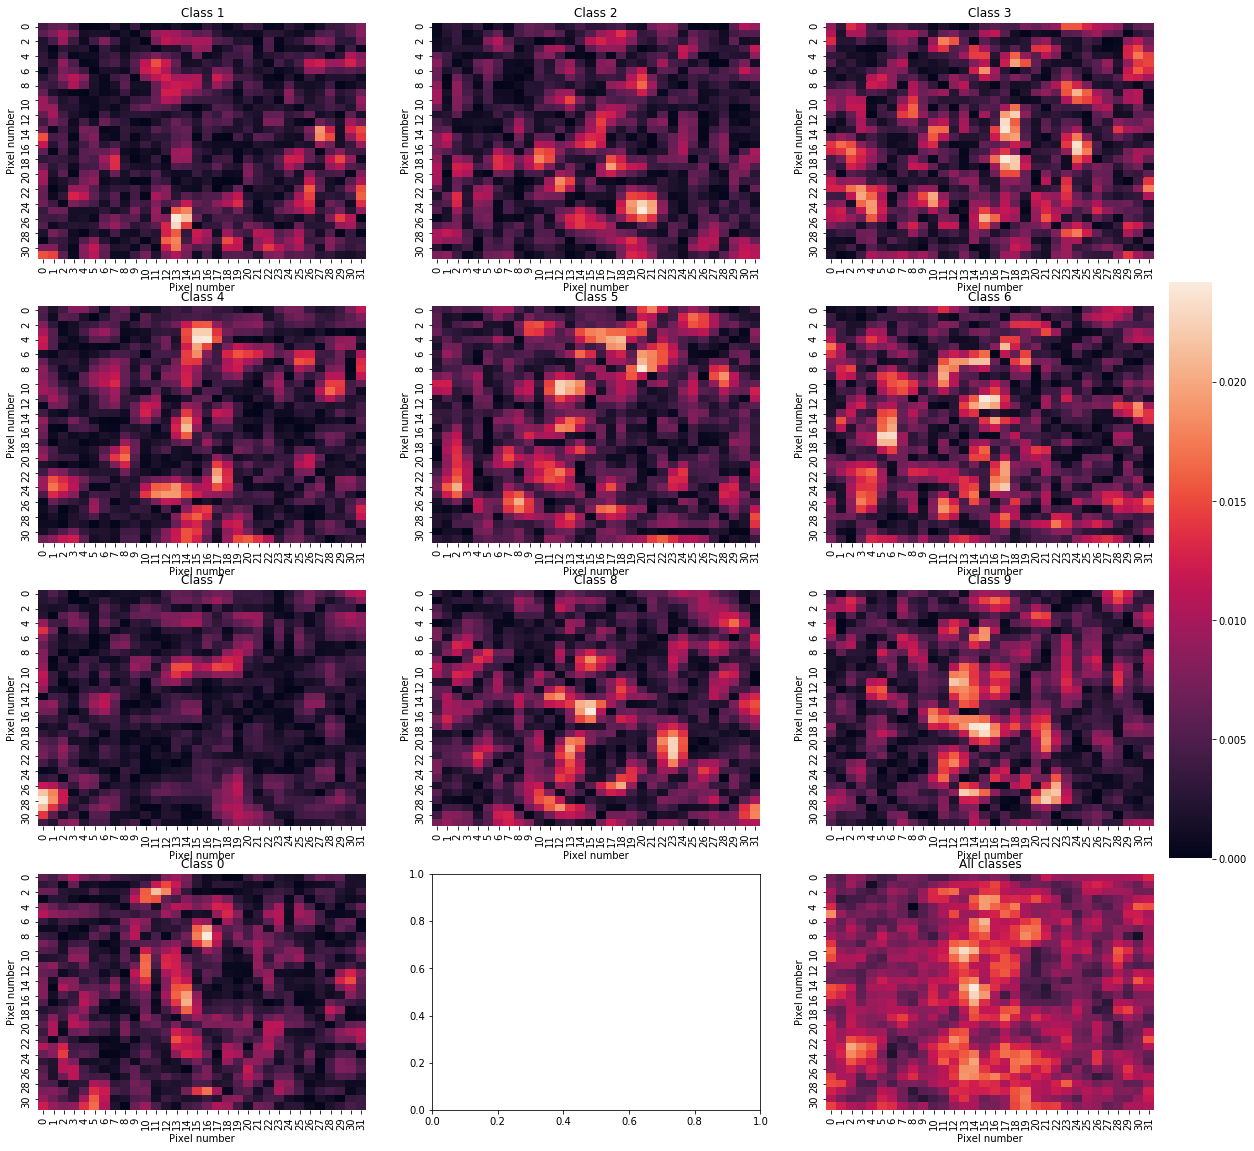

In [460]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20));

heatmap_class_1 = seaborn.heatmap(abs(class_1_matrix), ax=axes[0][0], cbar_ax = fig.add_axes([.91, .3, .03, .4]));
axes[0][0].title.set_text('Class 1')
axes[0][0].set_xlabel('Pixel number')
axes[0][0].set_ylabel('Pixel number')
heatmap_class_2 = seaborn.heatmap(abs(class_2_matrix), ax=axes[0][1], cbar=False);
axes[0][1].title.set_text('Class 2')
axes[0][1].set_xlabel('Pixel number')
axes[0][1].set_ylabel('Pixel number')
heatmap_class_3 = seaborn.heatmap(abs(class_3_matrix), ax=axes[0][2], cbar=False);
axes[0][2].title.set_text('Class 3')
axes[0][2].set_xlabel('Pixel number')
axes[0][2].set_ylabel('Pixel number')
heatmap_class_4 = seaborn.heatmap(abs(class_4_matrix), ax=axes[1][0], cbar=False);
axes[1][0].title.set_text('Class 4')
axes[1][0].set_xlabel('Pixel number')
axes[1][0].set_ylabel('Pixel number')
heatmap_class_5 = seaborn.heatmap(abs(class_5_matrix), ax=axes[1][1], cbar=False);
axes[1][1].title.set_text('Class 5')
axes[1][1].set_xlabel('Pixel number')
axes[1][1].set_ylabel('Pixel number')
heatmap_class_6 = seaborn.heatmap(abs(class_6_matrix), ax=axes[1][2], cbar=False);
axes[1][2].title.set_text('Class 6')
axes[1][2].set_xlabel('Pixel number')
axes[1][2].set_ylabel('Pixel number')
heatmap_class_7 = seaborn.heatmap(abs(class_7_matrix), ax=axes[2][0], cbar=False);
axes[2][0].title.set_text('Class 7')
axes[2][0].set_xlabel('Pixel number')
axes[2][0].set_ylabel('Pixel number')
heatmap_class_8 = seaborn.heatmap(abs(class_8_matrix), ax=axes[2][1], cbar=False);
axes[2][1].title.set_text('Class 8')
axes[2][1].set_xlabel('Pixel number')
axes[2][1].set_ylabel('Pixel number')
heatmap_class_9 = seaborn.heatmap(abs(class_9_matrix), ax=axes[2][2], cbar=False);
axes[2][2].title.set_text('Class 9')
axes[2][2].set_xlabel('Pixel number')
axes[2][2].set_ylabel('Pixel number')
heatmap_class_0 = seaborn.heatmap(abs(class_0_matrix), ax=axes[3][0], cbar=False);
axes[3][0].title.set_text('Class 0')
axes[3][0].set_xlabel('Pixel number')
axes[3][0].set_ylabel('Pixel number')

total_heatmap = seaborn.heatmap(total_matrix, ax=axes[3][2], cbar=False);
axes[3][2].title.set_text('All classes')
axes[3][2].set_xlabel('Pixel number');
axes[3][2].set_ylabel('Pixel number');

For both the SVM and Logistic model we plotted the absolute value of each weight of the corresponding feature, for each class individually. The plot in the lower right corner adds all absolute weight values together. We can see that the SVM model seems to focus on the first row of pixels on top of the images. We are not sure why this happens and it might be that the model is basically predicting the class on something else than the actual numbers in the images.

For the Logistic regression we can see much clearer that some parts of the digits are important. In the last plot one can see that the pixels around the center (where the actual digits are in the images) have a higher weight than the area surrounding the centre. This is in line with our hopes and expectations. 

Unfortunately we do not see clear digits in the visualisations. This might be due to the fact that we are training on only 3.5% of the dataset.

- Do the same for an underfitted and an overfitted version of logistic regression. What changes? Is the model paying attention to different parts of the image now?

In [466]:
#Underfitted model
LR_underfit= LogisticRegression(C=0.00000000001)
LR_underfit.fit(X_train, y_train);

In [341]:
#saving the model for future use
dump(LR_underfit, 'LR_underfit.joblib');

In [342]:
#Look at model accuracy
print("Train score: {}".format(LR_underfit.score(X_train, y_train)))

#Look at model accuracy
print("Test score: {}".format(LR_underfit.score(X_test, y_test)))

Train score: 0.2181294964028777
Test score: 0.1822759315206445


In [461]:
class_1_matrix = LR_underfit.coef_[0].reshape((32,32))
class_2_matrix = LR_underfit.coef_[1].reshape((32,32))
class_3_matrix = LR_underfit.coef_[2].reshape((32,32))
class_4_matrix = LR_underfit.coef_[3].reshape((32,32))
class_5_matrix = LR_underfit.coef_[4].reshape((32,32))
class_6_matrix = LR_underfit.coef_[5].reshape((32,32))
class_7_matrix = LR_underfit.coef_[6].reshape((32,32))
class_8_matrix = LR_underfit.coef_[7].reshape((32,32))
class_9_matrix = LR_underfit.coef_[8].reshape((32,32))
class_0_matrix = LR_underfit.coef_[9].reshape((32,32))
total_matrix = abs(class_1_matrix) + abs(class_2_matrix) + abs(class_3_matrix) + abs(class_4_matrix) + abs(class_5_matrix) + abs(class_6_matrix) +abs(class_7_matrix) + abs(class_8_matrix) + abs(class_9_matrix) + abs(class_0_matrix)

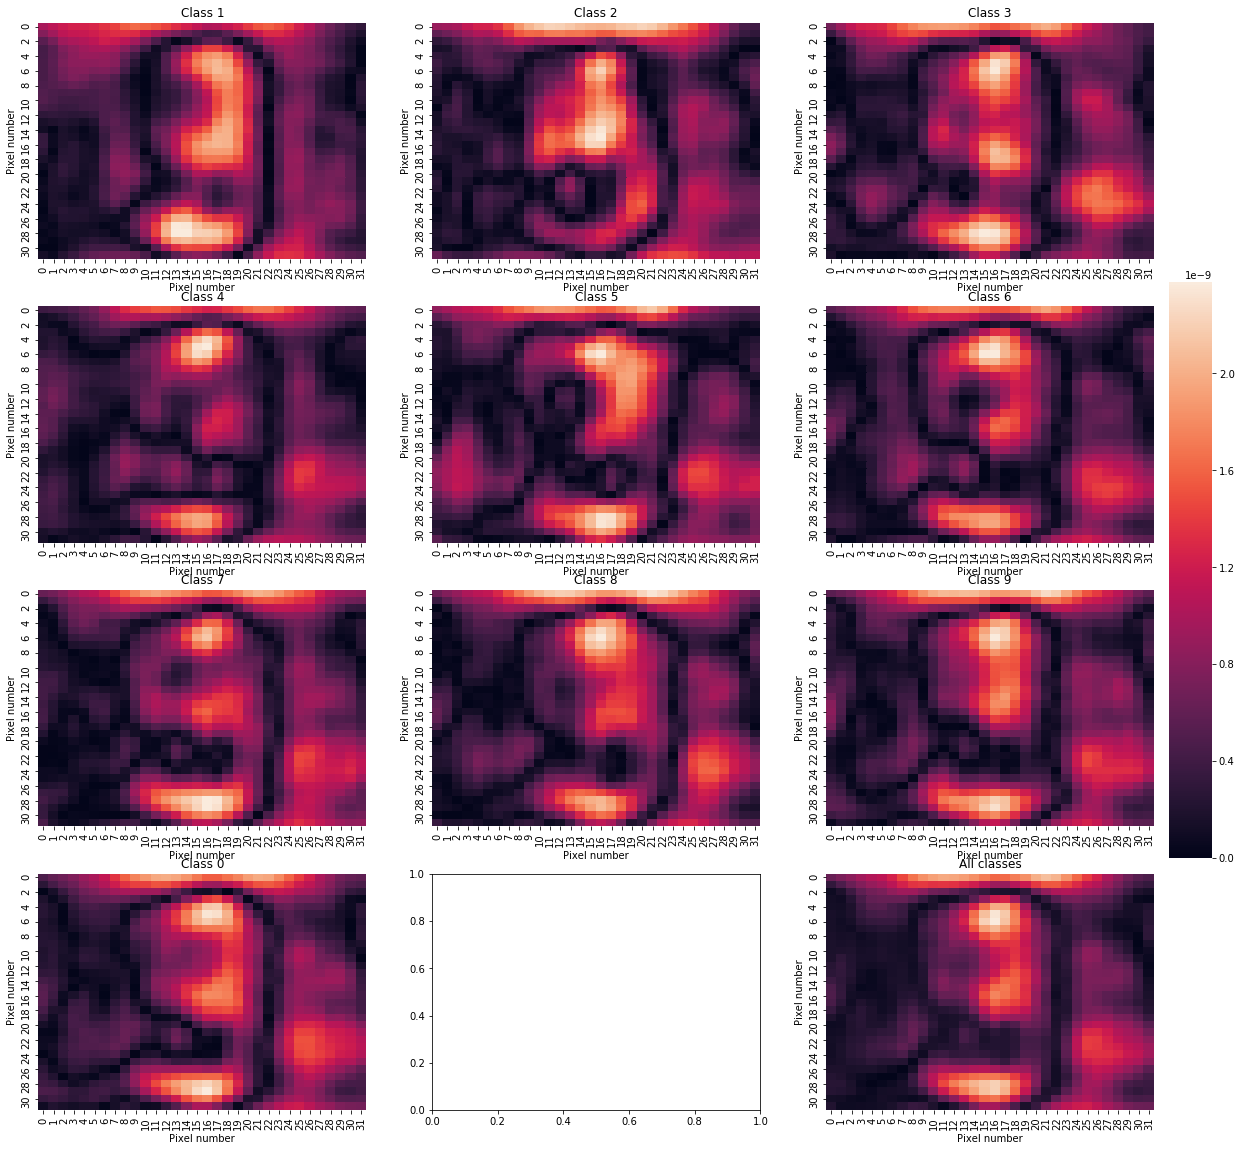

In [462]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20));

heatmap_class_1 = seaborn.heatmap(abs(class_1_matrix), ax=axes[0][0], cbar_ax = fig.add_axes([.91, .3, .03, .4]));
axes[0][0].title.set_text('Class 1')
axes[0][0].set_xlabel('Pixel number')
axes[0][0].set_ylabel('Pixel number')
heatmap_class_2 = seaborn.heatmap(abs(class_2_matrix), ax=axes[0][1], cbar=False);
axes[0][1].title.set_text('Class 2')
axes[0][1].set_xlabel('Pixel number')
axes[0][1].set_ylabel('Pixel number')
heatmap_class_3 = seaborn.heatmap(abs(class_3_matrix), ax=axes[0][2], cbar=False);
axes[0][2].title.set_text('Class 3')
axes[0][2].set_xlabel('Pixel number')
axes[0][2].set_ylabel('Pixel number')
heatmap_class_4 = seaborn.heatmap(abs(class_4_matrix), ax=axes[1][0], cbar=False);
axes[1][0].title.set_text('Class 4')
axes[1][0].set_xlabel('Pixel number')
axes[1][0].set_ylabel('Pixel number')
heatmap_class_5 = seaborn.heatmap(abs(class_5_matrix), ax=axes[1][1], cbar=False);
axes[1][1].title.set_text('Class 5')
axes[1][1].set_xlabel('Pixel number')
axes[1][1].set_ylabel('Pixel number')
heatmap_class_6 = seaborn.heatmap(abs(class_6_matrix), ax=axes[1][2], cbar=False);
axes[1][2].title.set_text('Class 6')
axes[1][2].set_xlabel('Pixel number')
axes[1][2].set_ylabel('Pixel number')
heatmap_class_7 = seaborn.heatmap(abs(class_7_matrix), ax=axes[2][0], cbar=False);
axes[2][0].title.set_text('Class 7')
axes[2][0].set_xlabel('Pixel number')
axes[2][0].set_ylabel('Pixel number')
heatmap_class_8 = seaborn.heatmap(abs(class_8_matrix), ax=axes[2][1], cbar=False);
axes[2][1].title.set_text('Class 8')
axes[2][1].set_xlabel('Pixel number')
axes[2][1].set_ylabel('Pixel number')
heatmap_class_9 = seaborn.heatmap(abs(class_9_matrix), ax=axes[2][2], cbar=False);
axes[2][2].title.set_text('Class 9')
axes[2][2].set_xlabel('Pixel number')
axes[2][2].set_ylabel('Pixel number')
heatmap_class_0 = seaborn.heatmap(abs(class_0_matrix), ax=axes[3][0], cbar=False);
axes[3][0].title.set_text('Class 0')
axes[3][0].set_xlabel('Pixel number')
axes[3][0].set_ylabel('Pixel number')

total_heatmap = seaborn.heatmap(total_matrix, ax=axes[3][2], cbar=False);
axes[3][2].title.set_text('All classes')
axes[3][2].set_xlabel('Pixel number');
axes[3][2].set_ylabel('Pixel number');

In [465]:
#Overfitted model
LR_overfit = LogisticRegression(C=10e7)
LR_overfit.fit(X_train, y_train);

In [467]:
#saving the model for future use
dump(LR_overfit, 'LR_overfit.joblib');

In [468]:
#Look at model accuracy
print("Train score: {}".format(LR_overfit.score(X_train, y_train)))

#Look at model accuracy
print("Test score: {}".format(LR_overfit.score(X_test, y_test)))

Train score: 0.9099280575539568
Test score: 0.13192346424974824


In [463]:
class_1_matrix = LR_overfit.coef_[0].reshape((32,32))
class_2_matrix = LR_overfit.coef_[1].reshape((32,32))
class_3_matrix = LR_overfit.coef_[2].reshape((32,32))
class_4_matrix = LR_overfit.coef_[3].reshape((32,32))
class_5_matrix = LR_overfit.coef_[4].reshape((32,32))
class_6_matrix = LR_overfit.coef_[5].reshape((32,32))
class_7_matrix = LR_overfit.coef_[6].reshape((32,32))
class_8_matrix = LR_overfit.coef_[7].reshape((32,32))
class_9_matrix = LR_overfit.coef_[8].reshape((32,32))
class_0_matrix = LR_overfit.coef_[9].reshape((32,32))
total_matrix = abs(class_1_matrix) + abs(class_2_matrix) + abs(class_3_matrix) + abs(class_4_matrix) + abs(class_5_matrix) + abs(class_6_matrix) +abs(class_7_matrix) + abs(class_8_matrix) + abs(class_9_matrix) + abs(class_0_matrix)

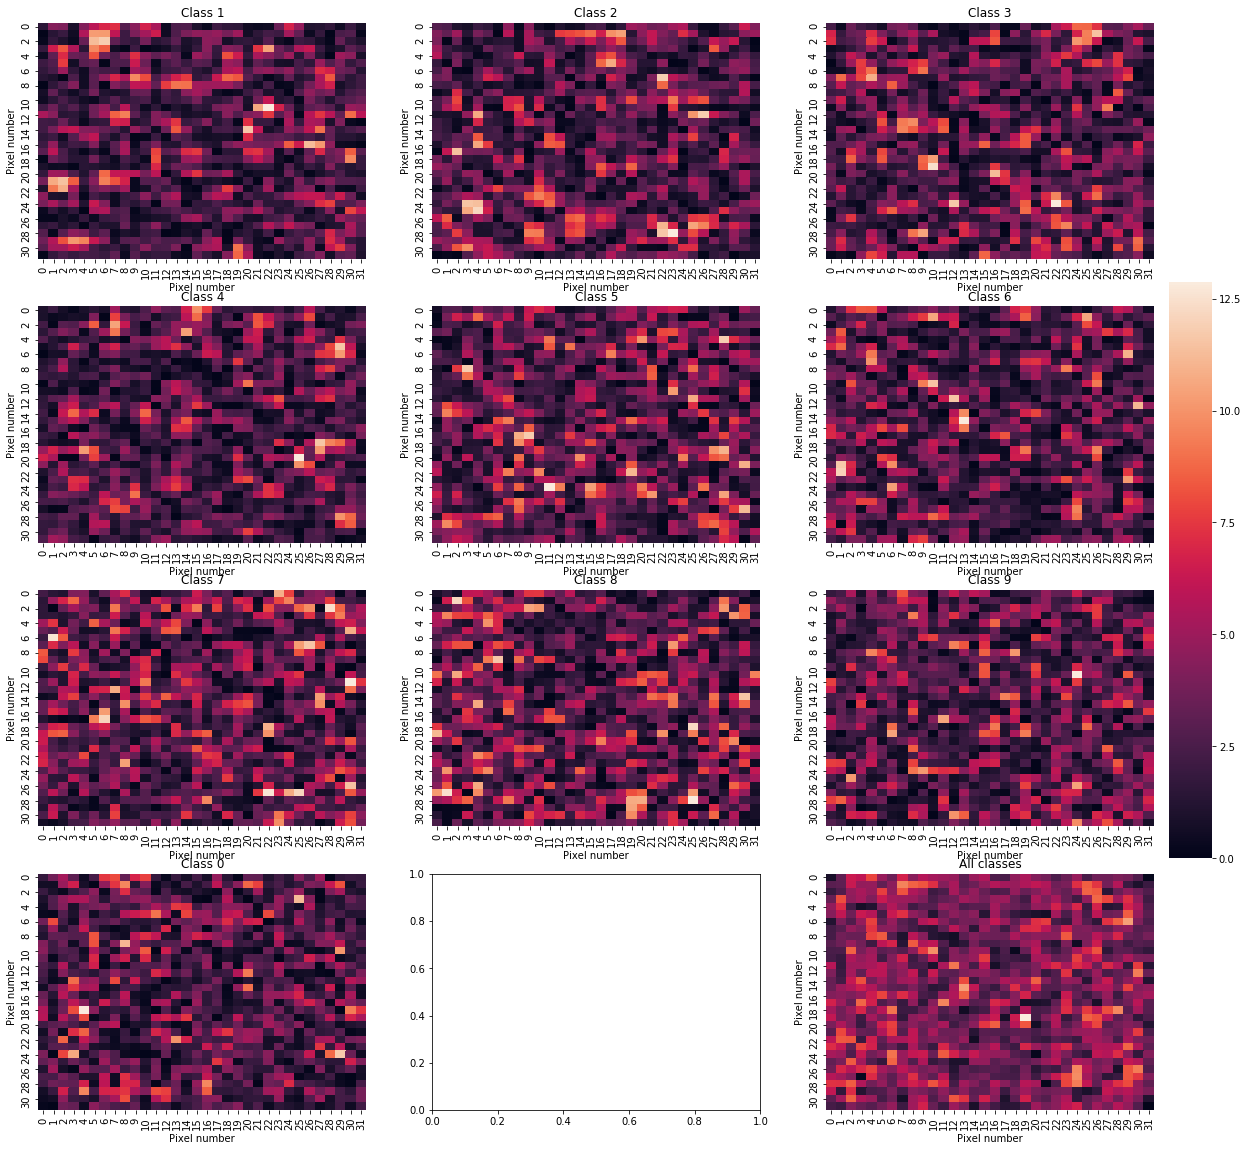

In [464]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20));

heatmap_class_1 = seaborn.heatmap(abs(class_1_matrix), ax=axes[0][0], cbar_ax = fig.add_axes([.91, .3, .03, .4]));
axes[0][0].title.set_text('Class 1')
axes[0][0].set_xlabel('Pixel number')
axes[0][0].set_ylabel('Pixel number')
heatmap_class_2 = seaborn.heatmap(abs(class_2_matrix), ax=axes[0][1], cbar=False);
axes[0][1].title.set_text('Class 2')
axes[0][1].set_xlabel('Pixel number')
axes[0][1].set_ylabel('Pixel number')
heatmap_class_3 = seaborn.heatmap(abs(class_3_matrix), ax=axes[0][2], cbar=False);
axes[0][2].title.set_text('Class 3')
axes[0][2].set_xlabel('Pixel number')
axes[0][2].set_ylabel('Pixel number')
heatmap_class_4 = seaborn.heatmap(abs(class_4_matrix), ax=axes[1][0], cbar=False);
axes[1][0].title.set_text('Class 4')
axes[1][0].set_xlabel('Pixel number')
axes[1][0].set_ylabel('Pixel number')
heatmap_class_5 = seaborn.heatmap(abs(class_5_matrix), ax=axes[1][1], cbar=False);
axes[1][1].title.set_text('Class 5')
axes[1][1].set_xlabel('Pixel number')
axes[1][1].set_ylabel('Pixel number')
heatmap_class_6 = seaborn.heatmap(abs(class_6_matrix), ax=axes[1][2], cbar=False);
axes[1][2].title.set_text('Class 6')
axes[1][2].set_xlabel('Pixel number')
axes[1][2].set_ylabel('Pixel number')
heatmap_class_7 = seaborn.heatmap(abs(class_7_matrix), ax=axes[2][0], cbar=False);
axes[2][0].title.set_text('Class 7')
axes[2][0].set_xlabel('Pixel number')
axes[2][0].set_ylabel('Pixel number')
heatmap_class_8 = seaborn.heatmap(abs(class_8_matrix), ax=axes[2][1], cbar=False);
axes[2][1].title.set_text('Class 8')
axes[2][1].set_xlabel('Pixel number')
axes[2][1].set_ylabel('Pixel number')
heatmap_class_9 = seaborn.heatmap(abs(class_9_matrix), ax=axes[2][2], cbar=False);
axes[2][2].title.set_text('Class 9')
axes[2][2].set_xlabel('Pixel number')
axes[2][2].set_ylabel('Pixel number')
heatmap_class_0 = seaborn.heatmap(abs(class_0_matrix), ax=axes[3][0], cbar=False);
axes[3][0].title.set_text('Class 0')
axes[3][0].set_xlabel('Pixel number')
axes[3][0].set_ylabel('Pixel number')

total_heatmap = seaborn.heatmap(total_matrix, ax=axes[3][2], cbar=False);
axes[3][2].title.set_text('All classes')
axes[3][2].set_xlabel('Pixel number');
axes[3][2].set_ylabel('Pixel number');

By evaluating the 32x32 matrixes of an underfitted and overfitted model there can be concluded that there are clear differences. The underfitted model shows matrices in which the significant areas, groups of pixels which are significant for predicting the class, are big and general areas. On the other hand, the over fitted model shows significant areas which are very small and specific. This means that there can be observed that the underfitted model has a more general approach on classifying a class while the overfitted model looks at very specific pixels to predict.